In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [26]:
data = pd.read_csv("data/data.csv", index_col=0)
x = data['streamer_name'].to_numpy()
y = data['interactivity'].to_numpy()

### EDA of Interactivity

Max: 1.0
Min: 6.800480654150321e-07
Mean: 0.08501977571357383
Standard diviation: 0.10526918200368014
Variance: 0.011081600679723934


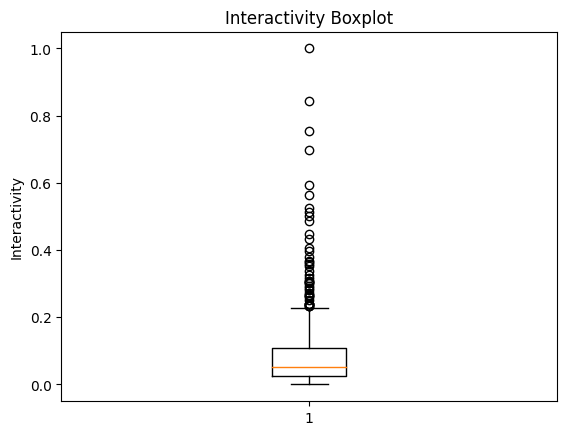

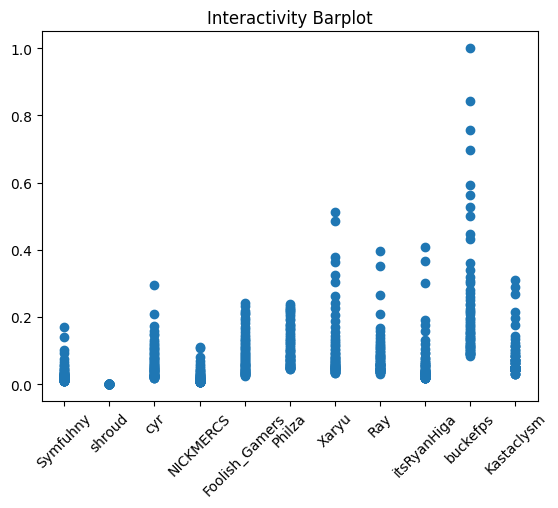

In [27]:
# Boxplot of interactivity
plt.boxplot(y)
plt.title("Interactivity Boxplot")
plt.ylabel("Interactivity")
print(f"Max: {np.max(y)}")
print(f"Min: {np.min(y)}")
print(f"Mean: {np.mean(y)}")
print(f"Standard diviation: {np.std(y)}")
print(f"Variance: {np.var(y)}")
plt.show()

# Barplot of interactivity
plt.plot(x,y, 'o')
plt.title("Interactivity Barplot")
plt.xticks(rotation=45)
plt.show()

### EDA of Acoustic Features

In [29]:
# Reading acoustic features from pickle and reorganizing them
acoustic_features = pd.read_pickle("feature_extraction/acousticfeatures.pkl")
X_acoustic_features_temp = []
for path in data['audio_path']:
    path = path.split('/')[-1]
    X_acoustic_features_temp.append((acoustic_features[acoustic_features['file'] == path]['feature vector']).to_numpy()[0])
X_acoustic_features = np.array(X_acoustic_features_temp)
del X_acoustic_features_temp

In [30]:
# Normalize acoustic features between -1 and 1 based on the min and max values of each index
X_acoustic_features = np.transpose(X_acoustic_features)
for i in range(len(X_acoustic_features)):    
    X_acoustic_features[i] = (X_acoustic_features[i] - np.min(X_acoustic_features[i])) / (np.max(X_acoustic_features[i]) - np.min(X_acoustic_features[i])) * 2 - 1
X_acoustic_features = np.transpose(X_acoustic_features)

Correlation between acoustic features and interactivity:
rolloff: -0.13841832296489032


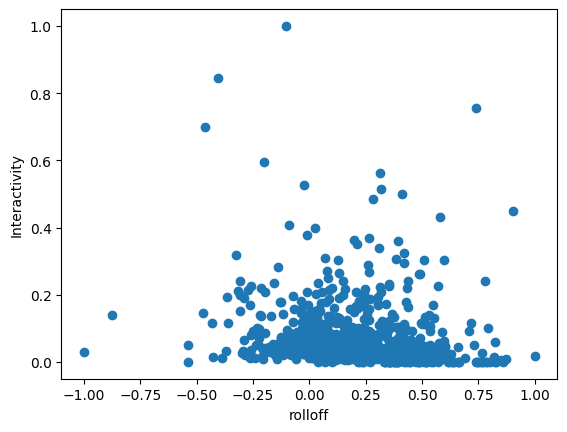

centroid: -0.16489352323162093


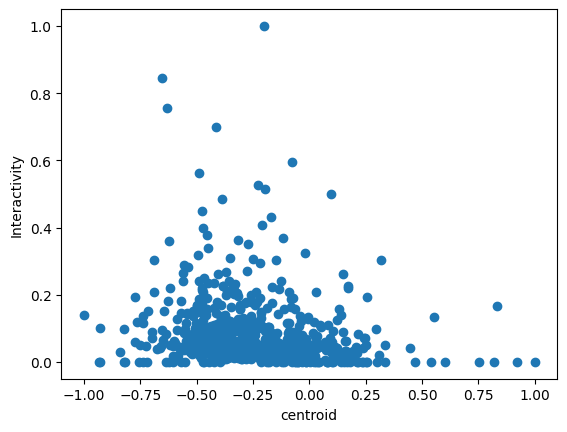

mel-frequency coefficients: -0.15254589040041805


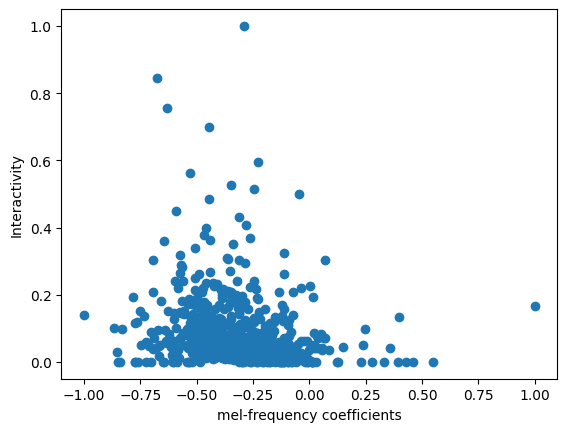

spectogram: -0.1769568918329386


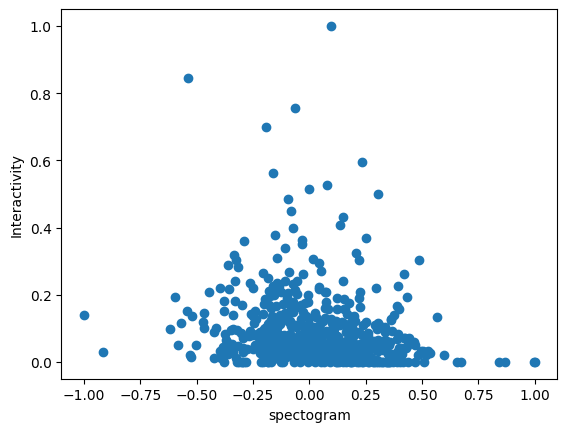

bandwidth: 0.07831001673734768


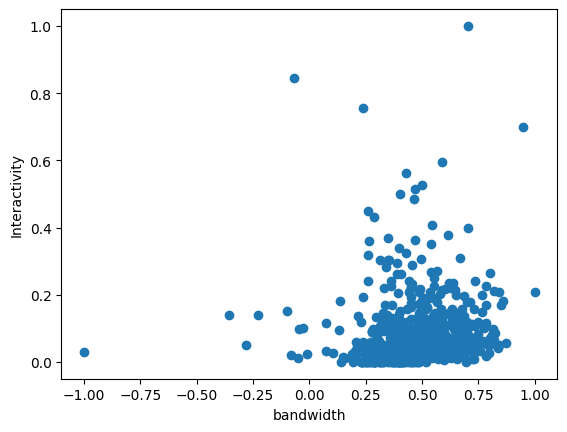

contrast: 0.09962917237090509


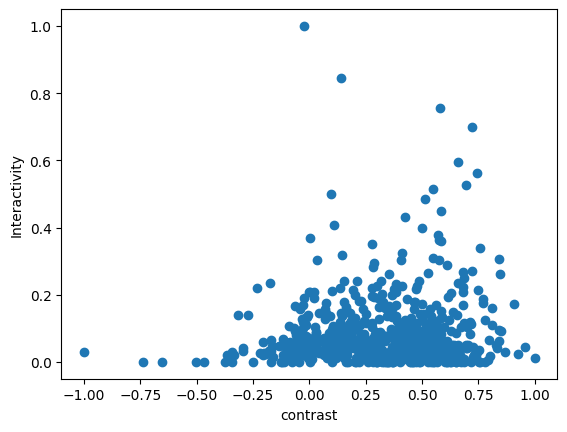

In [31]:
print("Correlation between acoustic features and interactivity:")
acoustic_feature_labels = {0: 'rolloff', 1: 'centroid', 2: 'mel-frequency coefficients', 3: 'spectogram', 4: 'bandwidth', 5: 'contrast'}
for i in range(6):
    print(f"{acoustic_feature_labels[i]}: {(np.corrcoef(np.transpose(X_acoustic_features)[i], y))[1][0]}")
    plt.plot(np.transpose(X_acoustic_features)[i], y, 'o')
    plt.xlabel(f"{acoustic_feature_labels[i]}")
    plt.ylabel('Interactivity')
    plt.show()


### EDA of Video Features

In [33]:
# Reading video features from pickle and reorganizing them
video_features = pd.read_pickle("feature_extraction/video/video_feature.pkl")
video_features['feature'] = video_features[['Number of Movement Spikes', "Maximum Movement Score"]].values.tolist()
X_video_features_temp = []
for path in data['video_path']:
    path = path.split('/')[-1]
    path = path.split('.')[0]
    X_video_features_temp.append((video_features[video_features['File'] == path]['feature']).to_numpy()[0])
X_video_features = np.array(X_video_features_temp)
del X_video_features_temp

In [34]:
# Normalize video features between -1 and 1 based on the min and max values of each index
X_video_features = np.transpose(X_video_features)
for i in range(len(X_video_features)):    
    X_video_features[i] = (X_video_features[i] - np.min(X_video_features[i])) / (np.max(X_video_features[i]) - np.min(X_video_features[i])) * 2 - 1
X_video_features = np.transpose(X_video_features)

Correlation between video features and interactivity:
Movement Spikes: 0.116427858907766


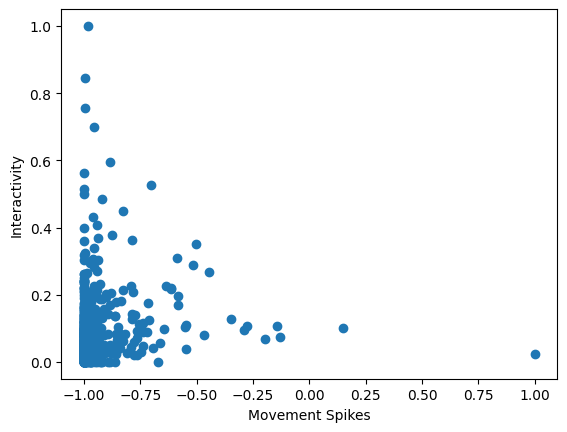

Movement Score: 0.14943118510309897


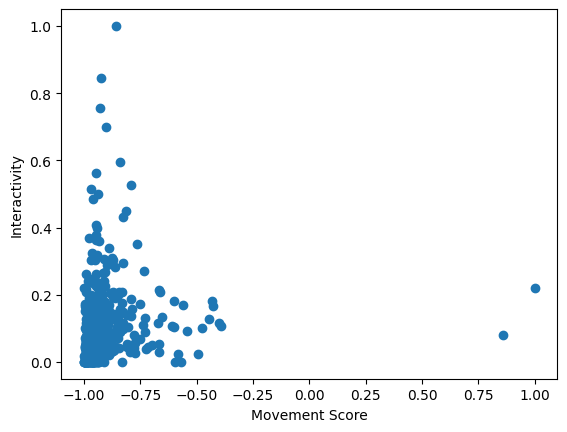

In [35]:
print("Correlation between video features and interactivity:")
video_feature_labels = {0: 'Movement Spikes', 1: 'Movement Score'}
for i in range(2):
    print(f"{video_feature_labels[i]}: {(np.corrcoef(np.transpose(X_video_features)[i], y))[1][0]}")
    plt.plot(np.transpose(X_video_features)[i], y, 'o')
    plt.xlabel(f"{video_feature_labels[i]}")
    plt.ylabel('Interactivity')
    plt.show()

### EDA of Transcript Features

In [49]:
# Reading transcript features from pickle and reorganizing them
transcript_features = pd.read_pickle("feature_extraction/transcript_features.pkl")
X_transcript_features_temp = []

for path in data['video_path']:
    path = path.split('/')[-1]
    path = path.split('.')[0]
    path = path + ".txt"
    X_transcript_features_temp.append((transcript_features[transcript_features['path'] == path]['feature']).to_numpy()[0])
X_transcript_features = np.array(X_transcript_features_temp)
del X_transcript_features_temp

In [54]:
data['audio_features'] = X_acoustic_features.tolist()
data['video_features'] = X_video_features.tolist()
data['transcript_features'] = X_transcript_features.tolist()
del X_acoustic_features, X_video_features, X_transcript_features

In [56]:
data['id'] = data['audio_path'].apply(lambda x: x.split('/')[-1].split('.')[0])

## Model Training

In [59]:
from sklearn.model_selection import train_test_split

In [241]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3)

In [246]:
def split_to_arr(x):
    return np.stack(x.to_numpy())

### Acoustic Feature Training

In [182]:
# Random forest
from sklearn.ensemble import RandomForestRegressor

random_forest_audio = RandomForestRegressor(n_estimators=500)
random_forest_audio.fit(split_to_arr(X_train['audio_features']), y_train)
y_rf_audio_pred = random_forest_audio.predict(split_to_arr(X_test['audio_features']))

### Video Feature Training

In [188]:
# Random forest
random_forest_video = RandomForestRegressor(n_estimators=500)
random_forest_video.fit(split_to_arr(X_train['video_features']), y_train)
y_rf_video_pred = random_forest_video.predict(split_to_arr(X_test['video_features']))

### Transcript Feature Training

In [158]:
# Random forest
random_forest_transcript = RandomForestRegressor(n_estimators=500)
random_forest_transcript.fit(split_to_arr(X_train['transcript_features']), y_train)
y_rf_transcript_pred = random_forest_transcript.predict(split_to_arr(X_test['transcript_features']))

### Fusion between each modality

In [131]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Concatenate, Dense, Input, Layer

In [135]:
class WeightedAverage(Layer):

    def __init__(self, n_output):
        super(WeightedAverage, self).__init__()
        self.W = tf.Variable(initial_value=tf.random.uniform(shape=[1,1,n_output], minval=0, maxval=1),
            trainable=True) # (1,1,n_inputs)

    def call(self, inputs):

        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim

        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

In [242]:
inp1 = Input((6,))
inp2 = Input((2,))
inp3 = Input((300,))
x1 = Dense(32, activation='relu')(inp1)
x1 = Dense(32, activation='relu')(inp1)
x2 = Dense(32, activation='relu')(inp2)
x2 = Dense(32, activation='relu')(inp2)
x3 = Dense(32, activation='relu')(inp2)
x3 = Dense(32, activation='relu')(inp2)
x = [x1,x2,x3]
W_Avg = WeightedAverage(n_output=len(x))(x)
out = Dense(1)(W_Avg)

m = Model([inp1,inp2,inp3], out)
m.compile('adam','mse')

m.fit([split_to_arr(X_train['audio_features']),split_to_arr(X_train['video_features']),split_to_arr(X_train['transcript_features'])], y_train, epochs=500)

Epoch 1/500
15/15 [==============================] - 1s 1ms/step - loss: 0.0913
Epoch 2/500
15/15 [==============================] - 0s 999us/step - loss: 0.0235
Epoch 3/500
15/15 [==============================] - 0s 999us/step - loss: 0.0119
Epoch 4/500
15/15 [==============================] - 0s 928us/step - loss: 0.0122
Epoch 5/500
15/15 [==============================] - 0s 923us/step - loss: 0.0117
Epoch 6/500
15/15 [==============================] - 0s 926us/step - loss: 0.0115
Epoch 7/500
15/15 [==============================] - 0s 926us/step - loss: 0.0114
Epoch 8/500
15/15 [==============================] - 0s 926us/step - loss: 0.0114
Epoch 9/500
15/15 [==============================] - 0s 898us/step - loss: 0.0113
Epoch 10/500
15/15 [==============================] - 0s 900us/step - loss: 0.0113
Epoch 11/500
15/15 [==============================] - 0s 972us/step - loss: 0.0113
Epoch 12/500
15/15 [==============================] - 0s 855us/step - loss: 0.0112
Epoch 13/500
15

In [243]:
y_pred = m.predict([split_to_arr(X_test['audio_features']),split_to_arr(X_test['video_features']),split_to_arr(X_test['transcript_features'])])

7/7 [==============================] - 0s 925us/step


## Model Evaluation

### Acoustic features model evaluation

Correlation between predicted values and actual values: 0.29232289464355554
Sum of squared errors: 1.3883885117312316


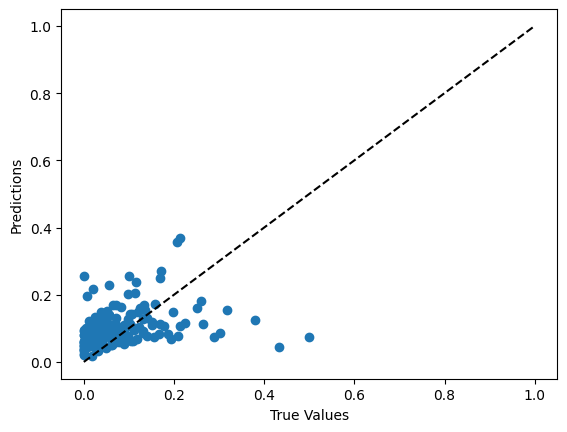

In [183]:
# Correlation between predicted and actual values
y_test = y_test.reshape(197,)
print("Correlation between predicted values and actual values:", np.corrcoef(y_rf_audio_pred, y_test)[0][1])

# Sum of squared errors
print("Sum of squared errors:", np.sum((y_rf_audio_pred - y_test)**2))

plt.plot(y_test, y_rf_audio_pred, 'o')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

### Video features model evaluation

Correlation between predicted values and actual values: 0.299888755811017
Sum of squared errors: 1.7619267672079455


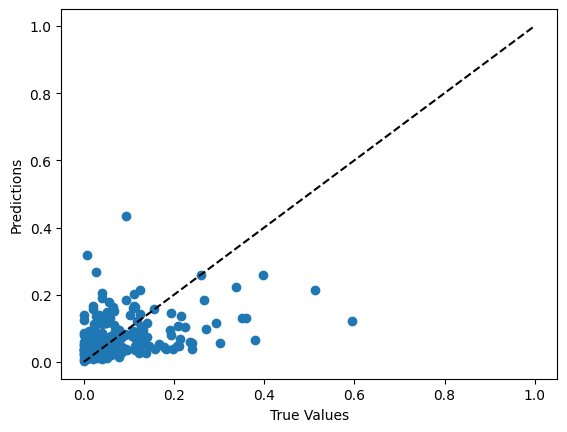

In [189]:
# Correlation between predicted and actual values
y_test = y_test.reshape(197,)
print("Correlation between predicted values and actual values:", np.corrcoef(y_rf_video_pred, y_test)[0][1])

# Sum of squared errors
print("Sum of squared errors:", np.sum((y_rf_video_pred - y_test)**2))

plt.plot(y_test, y_rf_video_pred, 'o')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

### Transcript features model evaluation

Correlation between predicted values and actual values: 0.03670884173898815
Sum of squared errors: 1.9782385937804925


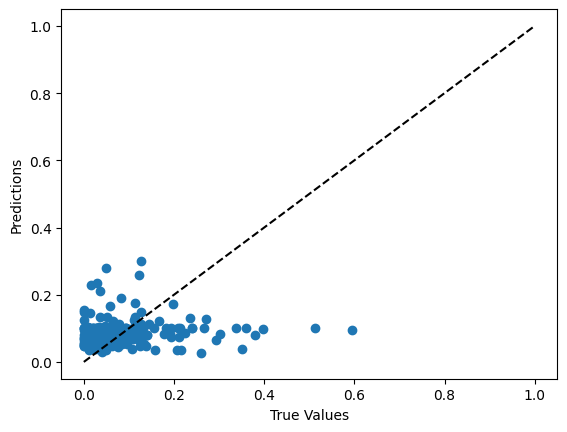

In [190]:
# Correlation between predicted and actual values
y_test = y_test.reshape(197,)
print("Correlation between predicted values and actual values:", np.corrcoef(y_rf_transcript_pred, y_test)[0][1])

# Sum of squared errors
print("Sum of squared errors:", np.sum((y_rf_transcript_pred - y_test)**2))

plt.plot(y_test, y_rf_transcript_pred, 'o')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

### Combined features model evaluation

Correlation between predicted values and actual values: 0.30422012002204185
Sum of squared errors: 1.6816486300870837


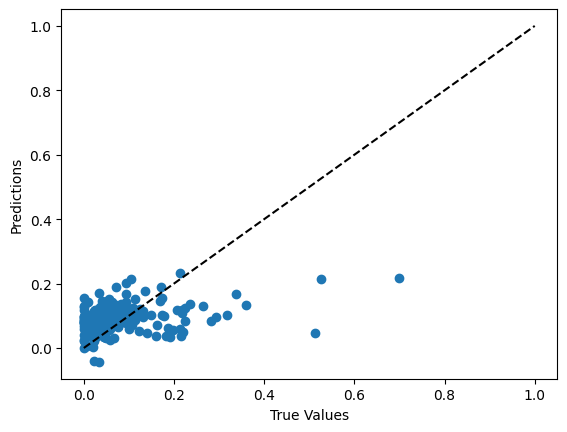

In [244]:
# Correlation between predicted and actual values
y_test = y_test.reshape(197,)
y_pred = y_pred.reshape(197,)
print("Correlation between predicted values and actual values:", np.corrcoef(y_pred, y_test)[0][1])

# Sum of squared errors
print("Sum of squared errors:", np.sum((y_pred - y_test)**2))

plt.plot(y_test, y_pred, 'o')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()